# Web of Life 2 (WoL2) genome selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from skbio.tree import TreeNode

In [3]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load metadata of WoL2 genomes. Available at [WoL2 FTP server](http://ftp.microbio.me/pub/wol2/genomes/)

In [4]:
df = pd.read_table(f'./input_data/assembly.tsv', sep = '\t', index_col = 0)
df.shape

(15953, 22)

Load checkM annotations. Available at [WoL2 FTP server](http://ftp.microbio.me/pub/wol2/genomes/)

In [5]:
checkm = pd.read_table(f'./input_data/checkm.tsv', sep = '\t', index_col = 0)
checkm.shape

(15953, 29)

Load GTDB taxonomy. [Avilable at WoL2 FTP server](http://ftp.microbio.me/pub/wol2/taxonomy/gtdb/)

In [6]:
levels = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
taxonomy = pd.read_csv(f'./input_data/lineages_gtdb.txt', index_col = 0, 
                     sep = r'\t|;', engine = 'python', header = None,
                    names = levels)
taxonomy = taxonomy.map(lambda x: x.strip())

In [7]:
taxonomy.shape

(15953, 7)

# Selection

## 1. Exclude incomplete genomes

In [8]:
df_quality = df.query('assembly_level == "Complete Genome" or assembly_level == "Chromosome"')
df_quality.shape

(2733, 22)

2. Exclude taxa with less than `num` representative taxa

In [9]:
taxonomy_quality = taxonomy.loc[df_quality.index]
taxonomy_quality.shape

(2733, 7)

In [10]:
num = 10
tmp = []
for level in levels[:-1]:
    counts = taxonomy_quality[taxonomy_quality[level].notna()][[level]].value_counts()
    for taxon in counts.index:
        # Avoid taxa such as g__ or f__
        if len(taxon[0].split('__')[1]) > 0:
            n = counts.loc[taxon]
            if n > num:
                tmp.append([level, taxon[0], n])
df_taxa = pd.DataFrame(tmp, columns = ['rank', 'taxon', 'counts'])

In [11]:
level = 'family'
taxa = df_taxa.query('rank == @level')['taxon'].values

In [12]:
sampled = taxonomy_quality[taxonomy_quality[level].isin(taxa)]
sampled.shape

(1510, 7)

In [13]:
genomes_sampled = sampled.index

Save selected genomes

In [14]:
with open(f'./output_data/genomes_sampled_family_{num}.txt', 'w') as f:
    for genome in genomes_sampled:
        f.write(f'{genome}\n')

## Figures

WoL2: reference tree. Available from [WoL2 FTP server](http://ftp.microbio.me/pub/wol2/phylogeny/)

In [15]:
wol_tree = TreeNode.read(f'../quality_inferred_trees/input_data/tree.nwk', format = 'newick')
print(wol_tree.count(tips = True))

15953


Shear tree to selected genomes

In [16]:
sheared = wol_tree.shear(genomes_sampled)
sheared.prune()

In [17]:
print(sheared.count(tips = True))

1510


Files for iTOL

In [18]:
# Assign domain to each node
node_clade_domain = {}
for node in sheared.postorder():
    if node.is_tip():
        node_clade_domain[node.name] = sampled.loc[node.name]['domain']
    else:
        child_domain_in_clade = set()
        for child in node.children:
            child_domain_in_clade.add(node_clade_domain[child.name])
        if len(child_domain_in_clade) == 1:
            node_clade_domain[node.name] = child_domain_in_clade.pop()
        else:
            node_clade_domain[node.name] = None

In [19]:
len(node_clade_domain)

2972

In [20]:
colors = ['#54478c', '#f29e4c', '#2c699a', '#f1c453', '#048ba8', '#efea5a',
            '#0db39e', '#b9e769', '#16db93', '#83e377',
            '#ffcaa6', '#fc989d', '#f86594', '#d78186', '#bd3658', '#b01041', '#838aa7']

In [21]:
# Add color to phylum
phylum_colors = {}
for i, phylum in enumerate(sampled['phylum'].value_counts().index):
    phylum_colors[phylum] = colors[i]

In [22]:
phylum_colors[None] = '#000000'

In [23]:
# Add color to domain
domain_colors = {'d__Bacteria': '#8d99ae', 'd__Archaea': '#2b2d42'}
domain_colors[None] = '#000000'

In [24]:
itol_content = [
        "DATASET_COLORSTRIP",
        "SEPARATOR TAB",
        f"DATASET_LABEL\tDomain Classification",
        f"COLOR\t#666666",
        f"COLOR_BRANCHES\t0",
        "DATA"]

In [25]:
for node in sheared.levelorder():
        itol_content.append(f'{node.name}\t{domain_colors[node_clade_domain[node.name]]}\t{node_clade_domain[node.name]}')

In [26]:
# Write to file
with open(f'./output_data/for_itol_wol2_colors_domain.txt', 'w') as f:
    f.write('\n'.join(itol_content))

In [27]:
sheared.write(f'./output_data/wol2_sheared.nwk', format = 'newick')

'./output_data/wol2_sheared.nwk'

In [28]:
itol_content = [
        #"DATASET_COLORSTRIP",
        #"SEPARATOR TAB",
        #f"DATASET_LABEL\tPhylum Classification",
        #f"COLOR\t#666666", # Default gray color for unannotated branches/lines
        "TREE_COLORS",
        "SEPARATOR TAB",
        "DATA"]

In [29]:
for phylum in sampled['phylum'].value_counts().index:
    # Get LCA
    lca = sheared.lca(sampled.query('phylum == @phylum').index)
    itol_content.append(f'{lca.name}\trange\t{phylum_colors[phylum]}\t{phylum.split("__")[1]}')

In [30]:
# Write to file
with open(f'./output_data/for_itol_wol2_colors_ranges.txt', 'w') as f:
    f.write('\n'.join(itol_content))

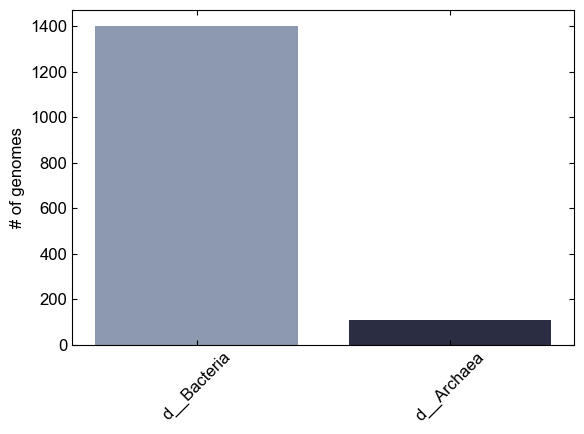

In [31]:
level = 'domain'
plt.figure(figsize = (6, 4.5))
datum = sampled[level].value_counts()
x = np.arange(len(datum))
plt.bar(x, datum.values, color = [domain_colors[t] for t in datum.index])
# plt.axhline(y = num, color = 'r', ls = 'dashed', lw = 1)
plt.tick_params(top=True, right=True, direction='in', which='both')
plt.xticks(x, labels = datum.index, rotation = 45)
plt.ylabel('# of genomes')
plt.savefig(f'./figures/figS1_B_domain.svg')
plt.show()

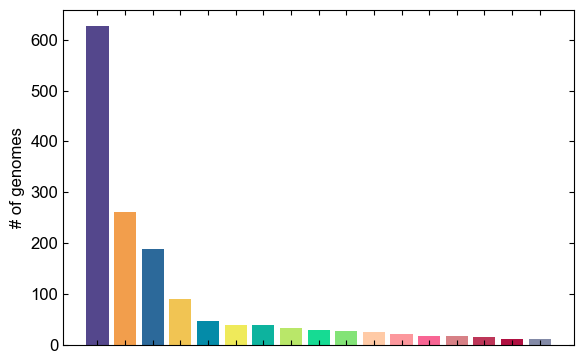

In [32]:
level = 'phylum'
plt.figure(figsize = (6, 3.8))
datum = sampled[level].value_counts()
x = np.arange(len(datum))
plt.bar(x, datum.values, color = [phylum_colors[t] for t in datum.index])
# plt.axhline(y = num, color = 'r', ls = 'dashed', lw = 1)
plt.tick_params(top=True, right=True, direction='in', which='both')
# plt.xticks(x, labels = datum.index, rotation = 45)
plt.xticks(x, [])
plt.ylabel('# of genomes')
plt.savefig(f'./figures/figS1_B_phylum.svg')
plt.show()